# Assignment2: Transformers
We will implement a Transformer from scratch.
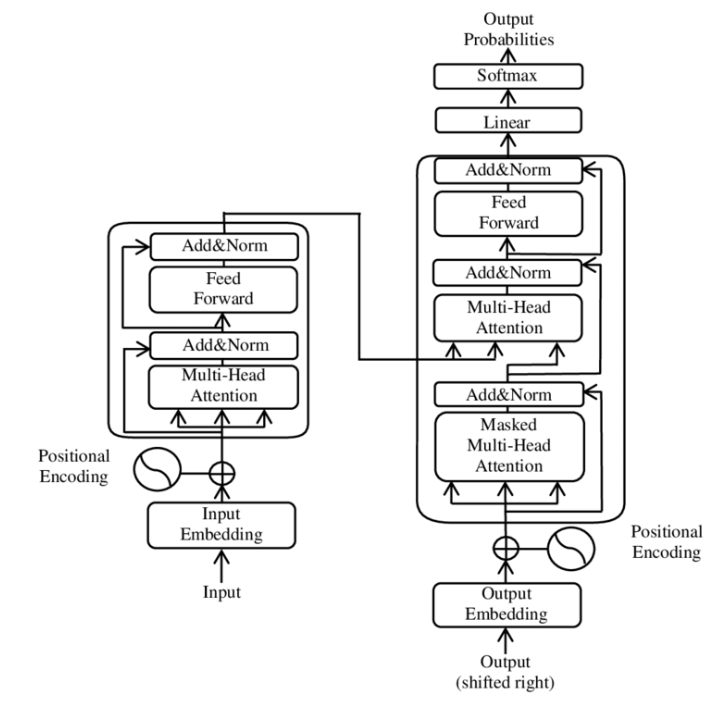




You will only need to fill one line of code after each "CODE HERE":

_\# CODE HERE_

 _Your code goes here_

In [112]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense,Input, Dropout, LayerNormalization
# from transformers import DistilBertTokenizerFast #, TFDistilBertModel
# from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm

### Positional Encoding

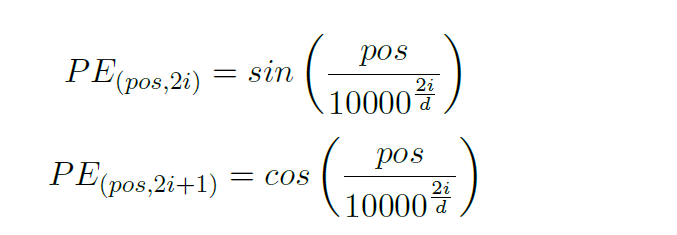

• d is the dimension of the word embedding and positional encoding

• pos is the position of the word.

• i refers to each of the different dimensions of the positional encoding.


In [113]:
def get_angles(pos, i, d):
    """
    Get the angles for the positional encoding
    Arguments:
    pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
    i -- Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
    d(integer) -- Encoding size
    Returns:
    angles -- (pos, d) numpy array
    """
    # CODE HERE
    
    return angles

In [114]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings
    Arguments:
    positions (int) -- Maximum number of positions to be encoded
    d (int) -- Encoding size
    Returns:
    pos_encoding -- (1, position, d_model) A matrix with the positionalencodings
    """
    # initialize a matrix angle_rads of all the angles
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
    np.arange(d)[np.newaxis, :],d)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

#### Visualize the positional encoding

(1, 50, 512)


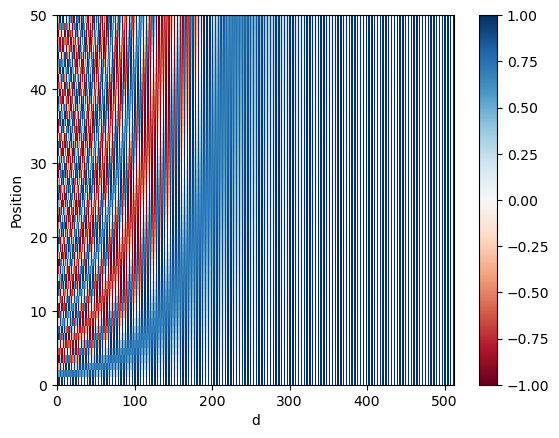

In [115]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()


### Padding Mask
There are two types of masks that are useful when building your Transformer network:
- the padding mask: Oftentimes your input sequence will exceed the maximum length of a sequence your network can
process. When passing sequences into a transformer model, it is important that they are of uniform length.
You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the
maximum length of your model
- The look-ahead mask: Sequences longer than the maximum length of five will be truncated. Similarly, for sequences shorter than the maximum length, they zeros will also be added for padding. However, these zeros will affect the softmax
calculation - this is when a padding mask comes in handy! You will need to define a boolean mask
that specifies which elements you must attend(1) and which elements you must ignore(0). Later
you will use that mask to set all the zeros in the sequence to a value close to negative infinity (-1e9).

In [116]:
def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    Arguments:
    seq -- (n, m) matrix
    Returns:
    mask -- (n, 1, 1, m) binary tensor
    """
    seq = 1 - tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]

In [117]:
#testing
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[[1. 1. 0. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]


 [[[0. 0. 0. 1. 1.]]]], shape=(3, 1, 1, 5), dtype=float32)


In [118]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9))

tf.Tensor(
[[7.2876638e-01 2.6809821e-01 6.6454895e-04 6.6454895e-04 1.8064313e-03]
 [8.4437370e-02 2.2952458e-01 6.2391245e-01 3.1062771e-02 3.1062771e-02]
 [4.8541022e-03 4.8541022e-03 4.8541022e-03 2.6502505e-01 7.2041267e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[[7.2973621e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00
    1.8088353e-03]
   [2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00
    9.0030566e-02]
   [6.6483538e-03 6.6483538e-03 0.0000000e+00 0.0000000e+00
    9.8670328e-01]]]


 [[[7.3057157e-01 2.6876229e-01 6.6619506e-04 0.0000000e+00
    0.0000000e+00]
   [9.0030566e-02 2.4472848e-01 6.6524088e-01 0.0000000e+00
    0.0000000e+00]
   [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00
    0.0000000e+00]]]


 [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105854e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01
    5.0000000e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105854e-01]]]], shape

### Look-ahead Mask

The look-ahead mask follows similar intuition. In training, you will have access to the complete
correct output of your training example. The look-ahead mask helps your model pretend that it
correctly predicted a part of the output and see if, without looking ahead, it can correctly predict
the next output.

In [119]:
def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones
    Arguments:
    size -- matrix size
    Returns:
    mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [120]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

If we multiply (1 - mask) by -1e9 and add it to the sample input sequences, the zeros are essentially
set to negative infinity. Notice the difference when taking the softmax of the original sequence and
the masked sequence:

### Self-attention

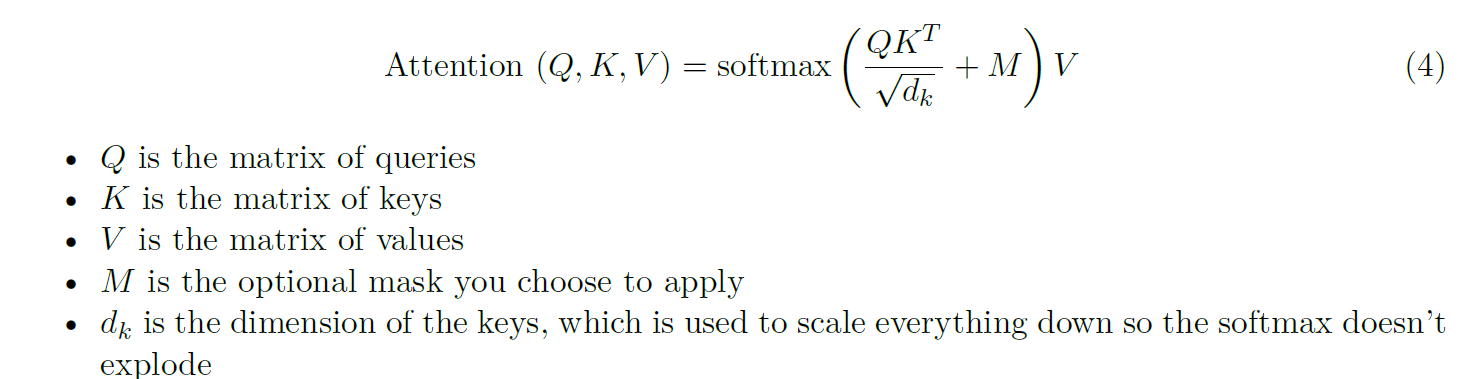

In [121]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k =seq_len_v.
    The mask has different shapes depending on its type(padding or lookahead)
    but it must be broadcastable for addition.
    Arguments:
    q -- query shape == (..., seq_len_q, depth)
    k -- key shape == (..., seq_len_k, depth)
    v -- value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
    to (..., seq_len_q, seq_len_k). Defaults to None.
    Returns:
    output -- attention_weights
    """
   
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q,seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (1-mask) * (-1e9)
    
    # CODE HERE:
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    
    # CODE HERE:
    # attention_weights * V
    
    return output, attention_weights

In [122]:
#Testing
q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)
k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32)
v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)
attention, weights = scaled_dot_product_attention(q, k, v, None)

assert np.allclose(weights, 
                   [[0.2589478, 0.42693272, 0.15705977, 0.15705977],
                    [0.2772748, 0.2772748, 0.2772748, 0.16817567],
                    [0.33620113, 0.33620113, 0.12368149, 0.2039163 ]])

### Encoder
Transformer encoder layer consists of:
- MultiHeadAttention you can think of as computing the self-attention several times to detect
different features.
- Feed forward neural network contains two Dense layers which we’ll implement as the function
FullyConnected

In [123]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
    tf.keras.layers.Dense(fully_connected_dim, activation='relu'), #(batch_size, seq_len, dff)
    tf.keras.layers.Dense(embedding_dim) # (batch_size, seq_len, d_model)
    ])

Steps in endoder:
1. You will pass the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute self -attention Q, V and K shouldbe the same.
2. Next, you will pass the output of the multi-head attention layer to a dropout layer. Don’t forget to use the training parameter to set the mode of your model.
3. Now add a skip connection by adding your original input x and the output of the dropout layer. 
4. After adding the skip connection, pass the output through the first layer normalization.
5. Finally, repeat steps 1-4 but with the feed forward neural network instead of the multi-head attention layer.

In [124]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network.
    This archirecture includes a residual connection around each of the two
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads,
        key_dim=embedding_dim)
        self.ffn = FullyConnected(embedding_dim=embedding_dim,
        fully_connected_dim=fully_connected_dim)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        
    def call(self, x, training=True, mask=None):
        """
        Forward pass for the Encoder Layer
        Arguments:
        x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        training -- Boolean, set to true to activate
        the training mode for dropout layers
        mask -- Boolean mask to ensure that the padding is not
        treated as part of the input
        Returns:
        out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
       
        # calculate self-attention using mha(~1 line)
        self_attn_output = self.mha(x,x,x,attention_mask=mask) # Self attention (batch_size,input_seq_len, embedding_dim)

        # apply dropout layer to the self-attention output (~1 line)
        self_attn_output = self.dropout1(self_attn_output,training=training)
        # apply layer normalization on sum of the input and the attentionoutput to get the
        # output of the multi-head attention layer (~1 line)
        mult_attn_out = self.layernorm1(x + self_attn_output) # (batch_size,input_seq_len, embedding_dim)
        
        # CODE HERE
        # pass the output of the multi-head attention layer through a ffn (~1line)
        
        # apply dropout layer to ffn output (~1 line)
        ffn_output = self.dropout2(ffn_output)
        
        # CODE HERE
        # apply layer normalization on sum of the output from multi-headattention and ffn output to get the
        # output of the encoder layer (~1 line)

        return encoder_layer_out

In [125]:
q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
encoder_layer1 = EncoderLayer(4, 2, 8)
tf.random.set_seed(10)
encoded = encoder_layer1.call(q, True, np.array([[1, 0, 1]]))

encoded

<tf.Tensor: shape=(1, 3, 4), dtype=float32, numpy=
array([[[-0.18797168,  0.2762453 , -1.4377744 ,  1.3495008 ],
        [-0.4283296 ,  1.6312648 , -1.0662135 , -0.13672149],
        [ 0.43380815,  0.9728879 , -1.6718264 ,  0.26513034]]],
      dtype=float32)>

In [126]:
# assert np.allclose(encoded.numpy(),
# [[-0.5214877 , -1.001476 , -0.12321664, 1.6461804 ],
# [-1.3114998 , 1.2167752 , -0.5830886 , 0.6778133 ],
# [ 0.25485858, 0.3776546 , -1.6564771 , 1.023964 ]],)

Now you’re ready to build the full Transformer Encoder, where you will embedd your input and add the positional encodings you calculated. You will then feed your encoded embeddings to a stack of Encoder layers.

In [127]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    encoder Layers
    """
    def __init__(self, num_layers, embedding_dim, num_heads,fully_connected_dim, input_vocab_size,
        maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
        self.embedding_dim)
        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
        num_heads=num_heads,
        fully_connected_dim=fully_connected_dim,
        dropout_rate=dropout_rate,
        layernorm_eps=layernorm_eps)
        for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training=True, mask=None):
        """
        Forward pass for the Encoder
        Arguments:
        x -- Tensor of shape (batch_size, input_seq_len)
        training -- Boolean, set to true to activate
        the training mode for dropout layers
        mask -- Boolean mask to ensure that the padding is not
        treated as part of the input
        Returns:
        out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]
       
        # Pass input through the Embedding layer
        x = self.embedding(x) # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embeddingdimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
        
        # CODE HERE
        # Add the position encoding to embedding
        
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x,training=training)
        # Pass the output through the stack of encoding layers
        for i in range(self.num_layers):
            x =self.enc_layers[i](x, training=training, mask=mask)
        return x # (batch_size, input_seq_len, embedding_dim)


In [128]:
#Testing
tf.random.set_seed(10)
embedding_dim=4
encoderq = Encoder(num_layers=2,
embedding_dim=embedding_dim,
num_heads=2,
fully_connected_dim=8,
input_vocab_size=32,
maximum_position_encoding=5)
x = np.array([[2, 1, 3], [1, 2, 0]])
padding_mask=np.array([1,1,1])
encoderq_output = encoderq.call(x, training=True, mask=None)

In [129]:
encoderq_output 

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[-0.74045324,  1.722923  , -0.5091084 , -0.47336134],
        [-0.40145928,  0.9755426 , -1.4537369 ,  0.8796535 ],
        [-0.44422653,  0.9606793 , -1.4300605 ,  0.91360784]],

       [[-1.4985551 ,  0.7041255 , -0.28943488,  1.0838645 ],
        [-0.57450783,  1.1656761 , -1.3291209 ,  0.7379525 ],
        [-0.95609456,  0.7345378 , -1.0121171 ,  1.2336738 ]]],
      dtype=float32)>

## Decoder

The Decoder layer takes the K and V matrices generated by the Encoder and in computes the
second multi-head attention layer with the Q matrix from the output.Again, you’ll pair multi-head attention with a feed forward neural network, but this time you’ll implement two multi-head attention layers. You will also use residual
connections and layer normalization to help speed up training

Implement DecoderLayer() using the call() method
1. Block 1 is a multi-head attention layer with a residual connection, dropout layer, and lookahead mask.
2. Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. You will then apply a dropout layer, layer normalization and a residual connection, just like you’ve done before.
3. Finally, Block 3 is a feed forward neural network with dropout and normalization layers and a residual connection.

Additional Hints: The first two blocks are fairly similar to the EncoderLayer except you will
return attention_scores when computing self-attention

In [130]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks,
    one that takes the new input and uses self-attention, and the other
    one that combines it with the output of the encoder, followed by a
    fully connected block.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(num_heads=num_heads,
        key_dim=embedding_dim)
        self.mha2 = MultiHeadAttention(num_heads=num_heads,
        key_dim=embedding_dim)
        self.ffn = FullyConnected(embedding_dim=embedding_dim,
        fully_connected_dim=fully_connected_dim)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)
        
    def call(self, x, enc_output, look_ahead_mask=None,training=True, padding_mask=None):
        """
        Forward pass for the Decoder Layer
        Arguments:
        x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
        enc_output -- Tensor of shape(batch_size, input_seq_len,embedding_dim)
        training -- Boolean, set to true to activate
        the training mode for dropout layers
        look_ahead_mask -- Boolean mask for the target_input
        padding_mask -- Boolean mask for the second multihead attentionlayer
        Returns:
        out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
        attn_weights_block1 -- Tensor of shape(batch_size, num_heads,target_seq_len, input_seq_len)
        attn_weights_block2 -- Tensor of shape(batch_size, num_heads,target_seq_len, input_seq_len)
        """
        
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)
        # BLOCK 1
        # calculate self-attention and return attention scores asattn_weights_block1 (~1 line)
        attn1, attn_weights_block1 = self.mha1(x, x, x, attention_mask=look_ahead_mask,return_attention_scores=True) # (batch_size, target_seq_len, d_model)
        # apply dropout layer on the attention output (~1 line)
        attn1 = self.dropout1(attn1,training=training)
        # apply layer normalization to the sum of the attention output and theinput (~1 line)
        out1 = self.layernorm1(attn1 + x)
        # BLOCK 2
       
        # CODE HERE
        # calculate self-attention using the Q from the first block and K and Vfrom the encoder output.
        # Return attention scores as attn_weights_block2 (~1 line)
        
        # apply dropout layer on the attention output (~1 line)
        attn2 = self.dropout2(attn2,training=training)
        
        # CODE HERE
        # apply layer normalization to the sum of the attention output and theoutput of the first block (~1 line)
        
        #BLOCK 3 
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(out2) # (batch_size, target_seq_len,embedding_dim)
        # apply a dropout layer to the ffn output
        ffn_output = self.dropout3(ffn_output)
        # apply layer normalization to the sum of the ffn output and the outputof the second block
        out3 = self.layernorm3(ffn_output+out2) # (batch_size, target_seq_len,embedding_dim)
       
        return out3, attn_weights_block1, attn_weights_block2

In [131]:
#Testing
num_heads=8
tf.random.set_seed(10)
decoderLayerq = DecoderLayer(embedding_dim=4,num_heads=num_heads,fully_connected_dim=32,dropout_rate=0.1,layernorm_eps=1e-6)

encoderq_output = tf.constant([[[-0.40172306, 0.11519244, -1.2322885, 1.5188192 ],
[ 0.4017268, 0.33922842, -1.6836855, 0.9427304 ],
[ 0.4685002, -1.6252842, 0.09368491, 1.063099 ]]])

q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
look_ahead_mask = tf.constant([[1., 0., 0.],[1., 1., 0.],[1., 1., 1.]])

out, attn_w_b1, attn_w_b2 = decoderLayerq(q, encoderq_output,look_ahead_mask=look_ahead_mask, training=True, padding_mask=None)

In [132]:
out

<tf.Tensor: shape=(1, 3, 4), dtype=float32, numpy=
array([[[ 0.86254543, -1.6094272 ,  0.8132314 , -0.06634969],
        [-1.4024733 ,  1.2804279 , -0.37836346,  0.5004089 ],
        [ 0.7922101 , -0.9480236 , -1.0314865 ,  1.1873001 ]]],
      dtype=float32)>

you will initialize your Decoder with an Embedding layer, positional encoding,
and multiple DecoderLayers. Your call() method will perform the following steps: 1. Pass your
generated output through the Embedding layer. 2. Scale your embedding by multiplying it by the
square root of your embedding dimension. Remember to cast the embedding dimension to data type
tf.float32 before computing the square root. 3. Add the position encoding: self.pos_encoding
[:, :seq_len, :] to your embedding. 4. Pass the encoded embedding through a dropout layer,
remembering to use the training parameter to set the model training mode. 5. Pass the output
of the dropout layer through the stack of Decoding layers using a for loop.

In [133]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder is starts by passing the target input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    decoder Layers
    """
    def __init__(self, num_layers, embedding_dim, num_heads,fully_connected_dim, target_vocab_size,
        maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)] 
        self.dropout = Dropout(dropout_rate)
            
    def call(self, x, enc_output, training=False,look_ahead_mask=None, padding_mask=None):
        """
        Forward pass for the Decoder
        Arguments:
        x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
        enc_output -- Tensor of shape(batch_size, input_seq_len,embedding_dim)
        training -- Boolean, set to true to activate
        the training mode for dropout layers
        look_ahead_mask -- Boolean mask for the target_input
        padding_mask -- Boolean mask for the second multihead attentionlayer
        Returns:
        x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
        attention_weights - Dictionary of tensors containing all theattention weights
        each of shape Tensor of shape (batch_size,num_heads, target_seq_len, input_seq_len)
        """
        seq_len = tf.shape(x)[1]
        attention_weights = {}
       
        # create word embeddings
        x = self.embedding(x) # (batch_size, target_seq_len, embedding_dim)
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]
        # apply a dropout layer to x
        x = self.dropout(x,training=training)
        # use a for loop to pass x through a stack of decoder layers and updateattention_weights (~4 lines total)
        for i in range(self.num_layers):
        # pass x and the encoder output through a stack of decoder layersand save the attention weights
        # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output,look_ahead_mask=look_ahead_mask, 
                                                   training=True, padding_mask=padding_mask)
            #update attention_weights dictionary with the attention weights ofblock 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] =block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)]= block2
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

In [134]:
tf.random.set_seed(10)
num_layers=7
embedding_dim=4
num_heads=3
fully_connected_dim=8
target_vocab_size=33
maximum_position_encoding=6
x = np.array([[3, 2, 1], [2, 1, 0]])
encoderq_output = tf.constant([[[-0.40172306, 0.11519244, -1.2322885, 1.5188192 ],
[ 0.4017268, 0.33922842, -1.6836855, 0.9427304 ],
[ 0.4685002, -1.6252842, 0.09368491, 1.063099 ]],
[[-0.3489219, 0.31335592, -1.3568854, 1.3924513 ],
[-0.08761203, -0.1680029, -1.2742313, 1.5298463 ],
[ 0.2627198, -1.6140151, 0.2212624 , 1.130033 ]]])
look_ahead_mask = tf.constant([[1., 0., 0.],
[1., 1., 0.],
[1., 1., 1.]])
decoderk = Decoder(num_layers,
embedding_dim,
num_heads,
fully_connected_dim,
target_vocab_size,
maximum_position_encoding)
outd, att_weights = decoderk(x, encoderq_output, training=False,look_ahead_mask=look_ahead_mask, padding_mask=None)

# assert np.allclose(outd[1, 1], [-0.2715261, -0.5606001, -0.861783, 1.69390933]), "Wrong values in outd"


## Transformers
The flow of data through the Transformer Architecture is as follows: * First your input passes
through an Encoder, which is just repeated Encoder layers that you implemented: 
- embedding and positional encoding of your input 
- multi-head attention on your input 
- feed forward neural network to help detect features

Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented: 
- embedding and positional encoding of the output
- multi-head attention on your generated output 
- multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder - a feed forward neural network to help detect features 
Finally, after the Nth Decoder layer, two dense layers and a softmax are applied to generate prediction for the next output in your sequence.

Pass the input through the Encoder with the appropiate mask. 2. Pass the encoder output and the target through the Decoder with the appropiate mask. 3. Apply a linear transformation and a softmax to get a prediction.

In [135]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads,fully_connected_dim, input_vocab_size,
        target_vocab_size, max_positional_encoding_input,
        max_positional_encoding_target, dropout_rate=0.1,layernorm_eps=1e-6):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers=num_layers,
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        fully_connected_dim=fully_connected_dim,
        input_vocab_size=input_vocab_size,
        maximum_position_encoding=max_positional_encoding_input,
        dropout_rate=dropout_rate,
        layernorm_eps=layernorm_eps)
        self.decoder = Decoder(num_layers=num_layers,
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        fully_connected_dim=fully_connected_dim,
        target_vocab_size=target_vocab_size,
        maximum_position_encoding=max_positional_encoding_target,
        dropout_rate=dropout_rate,
        layernorm_eps=layernorm_eps)
        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training=True, enc_padding_mask=None,look_ahead_mask=None, dec_padding_mask=None):
        """
        Forward pass for the entire Transformer
        Arguments:
        input_sentence -- Tensor of shape (batch_size, input_seq_len,fully_connected_dim)
        An array of the indexes of the words in the inputsentence
        output_sentence -- Tensor of shape (batch_size, target_seq_len,fully_connected_dim)
        An array of the indexes of the words in the output sentence
        training -- Boolean, set to true to activate
        the training mode for dropout layers
        enc_padding_mask -- Boolean mask to ensure that the padding is not
        treated as part of the input
        look_ahead_mask -- Boolean mask for the target_input
        padding_mask -- Boolean mask for the second multihead attentionlayer
        Returns:
        final_output -- Describe me
        attention_weights - Dictionary of tensors containing all theattention weights for the decoder
        each of shape Tensor of shape (batch_size,num_heads, target_seq_len, input_seq_len)
        """
      
        # call self.encoder with the appropriate arguments to get the encoderoutput
        enc_output = self.encoder(input_sentence, training=training, mask=enc_padding_mask) #batch_size, inp_seq_len, fully_connected_dim)
        
        # CODE HERE
        # call self.decoder with the appropriate arguments to get the decoderoutput
        
        # CODE HERE
        # pass decoder output through a linear layer and softmax (~2 lines)
        
        return final_output, attention_weights


## Test

In [136]:
# UNIT TEST
def Transformer_test(target):
    tf.random.set_seed(10)
    num_layers = 6
    embedding_dim = 4
    num_heads = 4
    fully_connected_dim = 8
    input_vocab_size = 30
    target_vocab_size = 35
    max_positional_encoding_input = 5
    max_positional_encoding_target = 6
    trans = Transformer(num_layers,
    embedding_dim,
    num_heads,
    fully_connected_dim,
    input_vocab_size,
    target_vocab_size,
    max_positional_encoding_input,
    max_positional_encoding_target)
    # 0 is the padding value
    sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
    sentence_lang_b = np.array([[3, 2, 1, 0, 0]])
    enc_padding_mask = np.array([[1, 1, 1, 1, 0]])
    dec_padding_mask = np.array([[1, 1, 1, 0, 0]])
    look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])
    translation, weights = trans(
    sentence_lang_a,
    sentence_lang_b,
    training=True,
    enc_padding_mask=enc_padding_mask,
    look_ahead_mask=look_ahead_mask,
    dec_padding_mask=dec_padding_mask
    )
    assert tf.is_tensor(translation), "Wrong type for translation. Output mustbe a tensor"
    shape1 = (sentence_lang_a.shape[0], max_positional_encoding_input,target_vocab_size)
    assert tuple(tf.shape(translation).numpy()) == shape1, f"Wrong shape. Weexpected {shape1}"
    print(translation[0, 0, 0:8])
#     assert np.allclose(translation[0, 0, 0:8],
#     [0.02586828, 0.01676807, 0.0179477, 0.03098963,0.0493824, 0.01899733, 0.01486511, 0.03177376]),"Wrong values in outd"
#     keys = list(weights.keys())
#     assert type(weights) == dict, "Wrong type for weights. It must be a dict"
#     assert len(keys) == 2 * num_layers, f"Wrong length for attention weights.It must be 2 x num_layers = {2*num_layers}"
#     assert tf.is_tensor(weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"
#     shape1 = (sentence_lang_a.shape[0], num_heads, sentence_lang_a.shape[1],sentence_lang_a.shape[1])
#     assert tuple(tf.shape(weights[keys[1]]).numpy()) == shape1, f"Wrong shape.We expected {shape1}"
#     assert np.allclose(weights[keys[0]][0, 0, 1], [0.4992985, 0.5007015, 0., 0., 0.]), f"Wrong values in weights[{keys[0]}]"
#     print(translation)
#     print("\033[92mAll tests passed")
#     Transformer_test(Transformer)

In [137]:
Transformer_test(Transformer)

tf.Tensor(
[0.02358744 0.04142406 0.0154393  0.02111502 0.02049521 0.02308123
 0.02997641 0.03925816], shape=(8,), dtype=float32)
